In [38]:
import clip
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from PIL import Image
import seaborn as sns
from sklearn.metrics import confusion_matrix
import torch

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [9]:
model, preprocess = clip.load("ViT-B/32", device=device)

In [10]:
# Define dataset path
training_damage_path = "../dataset/training/00-damage"
training_whole_path = "../dataset/training/01-whole"

validation_damage_path = "../dataset/validation/00-damage"
validation_whole_path = "../dataset/validation/01-whole"

In [24]:
def get_images_from_folder(folder_path):
    images = []
    for img_file in os.listdir(folder_path):
        if img_file.endswith(('.png', '.PNG', '.jpg', '.JPG', '.jpeg', '.JPEG')):
            image = preprocess(Image.open(os.path.join(folder_path, img_file))).unsqueeze(0).to(device)
            images.append(image)
    return torch.cat(images, dim=0)

def evaluate(images, label, text_descriptions):
    with torch.no_grad():
        image_features = model.encode_image(images)
        text_features = model.encode_text(clip.tokenize(text_descriptions).to(device))
        similarities = image_features @ text_features.T
        predictions = similarities.argmax(dim=1)
        correct_predictions = (predictions == label).sum().item()
    return correct_predictions, len(images)

In [51]:
def evaluate_multiple_classes(images, text_descriptions):
    with torch.no_grad():
        image_features = model.encode_image(images)
        text_features = model.encode_text(clip.tokenize(text_descriptions).to(device))
        similarities = image_features @ text_features.T
        # This will be a batch_size x num_descriptions matrix
        
        predictions = similarities.softmax(dim=-1)
        # Define a threshold for how you decide if damage is present
        threshold = 0.5
        predictions = (predictions > threshold).int()
        
        # Check for each class if the similarity is above the threshold
        damage_predictions = predictions[:, :3]  # Assuming the first 3 descriptions are for the damage types
        
    return damage_predictions

In [52]:
# Load pictures
training_damage_images = get_images_from_folder(training_damage_path)
training_whole_images = get_images_from_folder(training_whole_path)

validation_damage_images = get_images_from_folder(validation_damage_path)
validation_whole_images = get_images_from_folder(validation_whole_path)

damage_images = torch.cat((training_damage_images, validation_damage_images), dim=0)
whole_images = torch.cat((training_whole_images, validation_whole_images), dim=0)

# New text descriptions for multiple classes
text_descriptions = ["front damage", "side damage", "back damage"]

# Evaluate for multiple classes
damage_predictions = evaluate_multiple_classes(damage_images, text_descriptions)

# Output results
for i, prediction in enumerate(damage_predictions):
    print(f"Image {i+1} damage prediction: {prediction.cpu().numpy()}")

Image 1 damage prediction: [0 1 0]
Image 2 damage prediction: [0 1 0]
Image 3 damage prediction: [0 1 0]
Image 4 damage prediction: [0 1 0]
Image 5 damage prediction: [0 1 0]
Image 6 damage prediction: [0 1 0]
Image 7 damage prediction: [0 1 0]
Image 8 damage prediction: [0 1 0]
Image 9 damage prediction: [1 0 0]
Image 10 damage prediction: [0 1 0]
Image 11 damage prediction: [0 1 0]
Image 12 damage prediction: [0 1 0]
Image 13 damage prediction: [0 1 0]
Image 14 damage prediction: [0 1 0]
Image 15 damage prediction: [0 1 0]
Image 16 damage prediction: [1 0 0]
Image 17 damage prediction: [0 1 0]
Image 18 damage prediction: [0 1 0]
Image 19 damage prediction: [0 1 0]
Image 20 damage prediction: [0 1 0]
Image 21 damage prediction: [0 0 0]
Image 22 damage prediction: [0 1 0]
Image 23 damage prediction: [0 1 0]
Image 24 damage prediction: [0 1 0]
Image 25 damage prediction: [0 1 0]
Image 26 damage prediction: [0 1 0]
Image 27 damage prediction: [0 1 0]
Image 28 damage prediction: [0 1 0]
I

In [53]:
# Define a function to plot a confusion matrix
def plot_confusion_matrix(actual, predicted, damage_type):
    cm = confusion_matrix(actual, predicted)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for {damage_type} Damage')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

Accuracy for Front damage: 66.26%


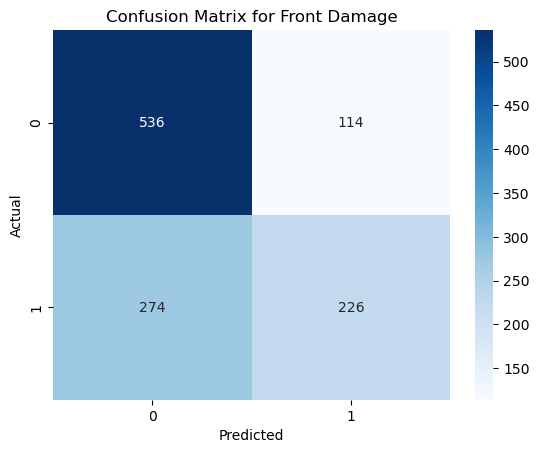

Accuracy for Side damage: 58.35%


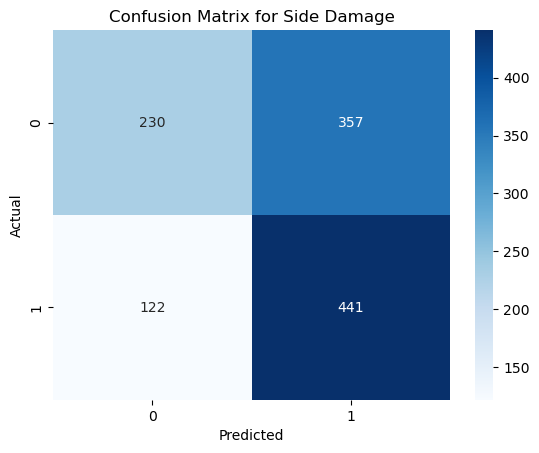

Accuracy for Back damage: 71.91%


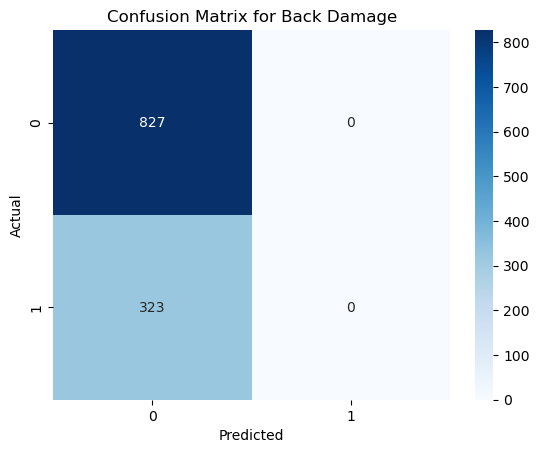

Overall accuracy for all damages: 40.00%


In [54]:
labels_csv_path = '../dataset/tag-damaged-car.xlsx'
labels_df = pd.read_excel(labels_csv_path)

# Fill missing values with 0 as per your description
labels_df = labels_df.fillna(0)
# print(labels_df)

# Convert predictions to a DataFrame
predictions_df = pd.DataFrame(damage_predictions.cpu().numpy(), columns=['Front', 'Side', 'Back'])
# print(predictions_df)

# Calculate accuracy for each damage type
accuracies = {}
for damage_type in ['Front', 'Side', 'Back']:
    correct_predictions = (labels_df[damage_type] == predictions_df[damage_type]).sum()
    accuracies[damage_type] = correct_predictions / len(labels_df)

# Calculate overall accuracy where all damage type predictions are correct
correct_overall_predictions = (labels_df[['Front', 'Side', 'Back']] == predictions_df[['Front', 'Side', 'Back']]).all(axis=1).sum()
overall_accuracy = correct_overall_predictions / len(labels_df)

# Print accuracies
for damage_type, accuracy in accuracies.items():
    print(f"Accuracy for {damage_type} damage: {accuracy * 100:.2f}%")
    plot_confusion_matrix(labels_df[damage_type], predictions_df[damage_type], damage_type)

# Calculate whole accuracy
# whole_actual = (labels_df[['Front', 'Side', 'Back']] == 0).all(axis=1)
# whole_predictions = (predictions_df[['Front', 'Side', 'Back']] == 0).all(axis=1)
# whole_correct = (whole_actual & whole_predictions).sum()
# whole_accuracy = whole_correct / whole_actual.sum()
# print(f"Accuracy for whole: {whole_accuracy * 100:.2f}%")

print(f"Overall accuracy for all damages: {overall_accuracy * 100:.2f}%")